In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [16]:
t_max = 30
epsilon = 1e-6
N_t = 150
l=1.0
w=10.0

lr = 0.5e-3
layers = 4
neuronas = 20
epocs = 20_000

In [17]:
# Modelo

class FunAct(nn.Module):
    def forward(self,x):
        return torch.tanh(x)


class MLP(nn.Module):
    def __init__(self, in_dim=1, out_dim=1, width=neuronas, depth=layers):
        super().__init__()
        capas = [nn.Linear(in_dim, width), FunAct()]
        for _ in range(depth - 1):
            capas += [nn.Linear(width, width), FunAct()]
        capas +=[nn.Linear(width, out_dim)]
        self.net=nn.Sequential(*capas)    

    def forward(self, x):
        return self.net(x)

In [18]:
u = MLP().to(device)

In [19]:
def D(y, x):
    return torch.autograd.grad(y,x, torch.ones_like(y), retain_graph = True, create_graph= True)[0]
def R(u,t):
    
    

    u_t = D(u,t)
    u_tt = D(u_t,t)

    return w*w*u + 2*u_t + u_tt

def u_forward(t):
    return u(t)

In [20]:
def muestreo(N):
    return torch.rand(N, 1, device=device)*(t_max - epsilon) + epsilon

In [21]:
optimizador = torch.optim.Adam(u.parameters(), lr)

In [ ]:
loss_valores = []

for step in range(epocs):

    optimizador.zero_grad()

    t_i = muestreo(N_t).clone().detach().requires_grad_()
    #u_i = u_forward(t_i)
    R_i = R(u(t_i),t_i)
    
    # Condiciones de borde (CB): u(0) = ℓ
    t0 = torch.tensor([[0.0]], device=device, requires_grad=True)
    u_t0 = D(u(t0),t0)
    
    u0 = u(t0)  # debería valer ℓ
    

    # Definir la pérdida asociada a esas condiciones
    ci1_loss = ((u0 - torch.tensor([[1.0]], device=device, requires_grad=False)*l)**2).mean() 

    ci2_loss = ((u_t0 - torch.tensor([[0.0]], device=device, requires_grad=False))**2).mean()


    loss = (R_i*R_i).mean() + ci1_loss + ci2_loss

    loss_valores.append(loss.item())

    loss.backward()

    optimizador.step()

    if step % 200 == 0:
        print(f"step {step:4d} | loss {loss.item():.3e}")


step    0 | loss 1.921e+01
step  200 | loss 1.024e+00
step  400 | loss 9.961e-01
step  600 | loss 9.946e-01
step  800 | loss 9.959e-01
step 1000 | loss 9.895e-01
step 1200 | loss 9.828e-01
step 1400 | loss 9.933e-01
step 1600 | loss 1.009e+00
step 1800 | loss 9.870e-01
step 2000 | loss 9.792e-01
step 2200 | loss 9.983e-01
step 2400 | loss 9.991e-01
step 2600 | loss 9.795e-01
step 2800 | loss 9.999e-01
step 3000 | loss 9.825e-01
step 3200 | loss 9.793e-01
step 3400 | loss 9.938e-01
step 3600 | loss 9.748e-01
step 3800 | loss 1.009e+00
step 4000 | loss 9.745e-01
step 4200 | loss 9.761e-01
step 4400 | loss 9.802e-01
step 4600 | loss 9.974e-01
step 4800 | loss 1.005e+00
step 5000 | loss 9.682e-01
step 5200 | loss 9.610e-01
step 5400 | loss 9.742e-01
step 5600 | loss 9.900e-01
step 5800 | loss 9.713e-01
step 6000 | loss 1.029e+00
step 6200 | loss 9.905e-01
step 6400 | loss 9.713e-01
step 6600 | loss 9.834e-01
step 6800 | loss 9.715e-01
step 7000 | loss 9.707e-01
step 7200 | loss 9.668e-01
s

Text(0.5, 1.0, 'loss')

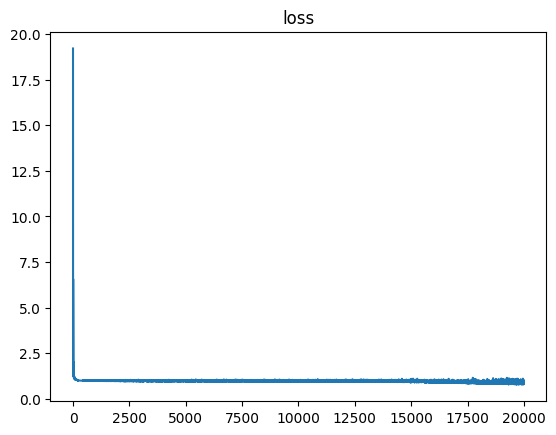

In [23]:
plt.plot(loss_valores)
plt.title('loss')

Text(0, 0.5, 'Loss')

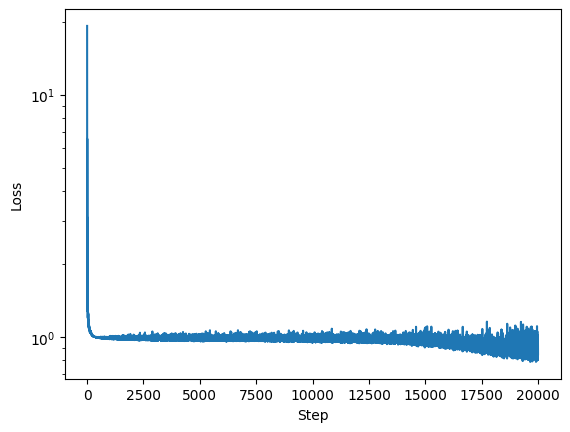

In [24]:
import matplotlib.pyplot as plt
plt.plot(loss_valores)
plt.yscale('log')  # si baja exponencialmente
plt.xlabel("Step"); plt.ylabel("Loss")

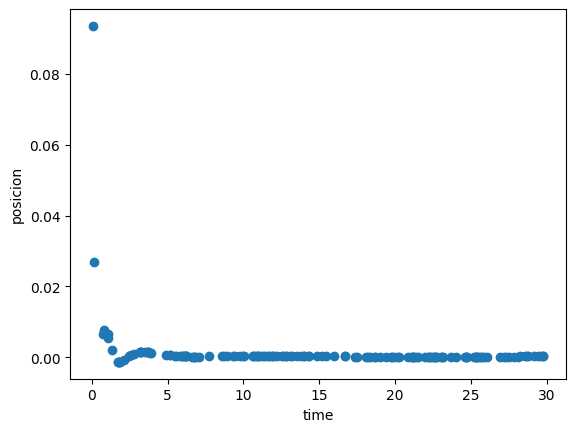

In [25]:
with torch.no_grad():
    t_vals = t_i.detach().cpu().numpy()
    u_vals = u(t_i).detach().cpu().numpy()

def u_esacta(t):
    return l*np.exp(t/2)*(np.cos(np.sqrt(3)*t/2) - np.sin(np.sqrt(3)*t/2)/np.sqrt(3))

t_poblado = np.linspace(0,10,len(t_vals))

plt.scatter(t_vals,u_vals)
#plt.plot(t_poblado,u_esacta(t_poblado),'orange')
plt.xlabel('time')
plt.ylabel('posicion')
plt.show()